In [9]:
!pip install prettytable
!pip install rdflib
!pip install xxhash
!pip install bitarray

  Obtaining dependency information for prettytable from https://files.pythonhosted.org/packages/25/1e/4c284713b092ec384fad4399452f43f6446ad9aabc9c0b3c3c0920cc53b6/prettytable-3.8.0-py3-none-any.whl.metadata


In [27]:
import pickle
from prettytable import PrettyTable
from rdflib import Graph
import time
import sqlite3
import matplotlib.pyplot as plt

In [ ]:
# Load the 10m store file into a graph, loop through it and find the unique properties and their count

graph = Graph()
file_path = 'watdiv.10M.nt'
graph.parse(file_path, format='nt')

distinct_prop = set()

for triple in graph:
    subject, predicate, obj = triple
    distinct_prop.add(str(predicate))

num_properties = len(distinct_prop)

print("No. of unique properties:", num_properties)

In [ ]:
# Save date into a pickle file to make it so we dont have to perform the unique prop finding step repeatedly

with open('distinct_prop.pkl', 'wb') as distinct_prop_file:
  pickle.dump(distinct_prop, distinct_prop_file) 

file = open("distinct_prop.pkl",'rb')
distinct_prop = pickle.load(file)
file.close()

In [ ]:
dictionary_properties= {}
for prop in distinct_prop:
    temp=prop.replace('#','/').split('/')
    abbr=temp[-1]
    dictionary_properties[prop]=abbr

print(dictionary_properties)   

In [ ]:
# Create a sqlite3 db and insert vertically partitioned tables for each distinct property for the 10 million record file

graph = Graph()
file_path = 'watdiv.10M.nt'
graph.parse(file_path, format='nt')

db_connection = sqlite3.connect('vertical_partition_rdf.db')
db_cursor = db_connection.cursor()

for i in distinct_prop:
    table_name = dictionary_properties[str(i)]
    db_cursor.execute(f'''
        CREATE TABLE IF NOT EXISTS {table_name} (
            Subject TEXT,
            Object TEXT
        )
    ''')

for t in graph:
    subject, predicate, obj = t
    table_name = dictionary_properties[str(predicate)]
    subject = str(subject)
    obj = str(obj)
    str_subject=subject.replace('#','/').split('/')[-1]
    str_object=obj.replace('#','/').split('/')[-1]
    
    db_cursor.execute(f'INSERT INTO {table_name} (Subject, Object) VALUES (?, ?)', (str_subject, str_object))

db_connection.commit()
db_connection.close()

In [4]:
# Get the first 10 entries of the tables required just to verify data
try:
    sqliteConnection = sqlite3.connect('vertical_partition_rdf.db')
     
    print("Connected to SQLite")
 
    sql_query = """SELECT * FROM hasReview,likes,friendOf,follows LIMIT 10
     ;"""
 
    cursor = sqliteConnection.cursor()
     
    cursor.execute(sql_query)
    print("List of tables\n")
     
    print(cursor.fetchall())
 
except sqlite3.Error as error:
    print("Failed to execute the above query", error)
     
finally:
    if sqliteConnection:
        sqliteConnection.close()
        print("the sqlite connection is closed")

Connected to SQLite
List of tables

[('Product10327', 'Review129280', 'User51149', 'Product2317', 'User76364', 'User28613', 'User65215', 'User57594'), ('Product10327', 'Review129280', 'User51149', 'Product2317', 'User76364', 'User28613', 'User91121', 'User65398'), ('Product10327', 'Review129280', 'User51149', 'Product2317', 'User76364', 'User28613', 'User18570', 'User99949'), ('Product10327', 'Review129280', 'User51149', 'Product2317', 'User76364', 'User28613', 'User21810', 'User87976'), ('Product10327', 'Review129280', 'User51149', 'Product2317', 'User76364', 'User28613', 'User16135', 'User10419'), ('Product10327', 'Review129280', 'User51149', 'Product2317', 'User76364', 'User28613', 'User28937', 'User55516'), ('Product10327', 'Review129280', 'User51149', 'Product2317', 'User76364', 'User28613', 'User91771', 'User8140'), ('Product10327', 'Review129280', 'User51149', 'Product2317', 'User76364', 'User28613', 'User55835', 'User41505'), ('Product10327', 'Review129280', 'User51149', 'Produ

In [ ]:
# Insert tables made upon the 100k records file, partitioned by each unique predicate

db_connection = sqlite3.connect('vertical_partition_rdf.db')
cursor = db_connection.cursor()
try:
    cursor.execute("BEGIN")
    cursor.execute("SAVEPOINT sp")

    with open('100k.txt', 'r') as file: 
        for l in file:
            l = l.replace('.',' ').strip()
            if not l:
                continue  
            divv = l.split('\t')
            subj, table, obj = divv
            subj=subj.split(':')[-1]
            table=table.split(':')[-1]
            obj=obj.split(':')[-1]
            cursor.execute(f'INSERT INTO {table} (Subject, Object) VALUES (?, ?)', (subj, obj))

    cursor.execute("ROLLBACK TO sp")
    cursor.execute("RELEASE sp")
    cursor.execute("COMMIT")

    db_connection.close()

except sqlite3.Error as e:
        cursor.execute("ROLLBACK")
        db_connection.close()
        print(f"An error occurred: {e}")

In [2]:
# Grab the 4 tables required in the query to reduce memory strain

conn = sqlite3.connect('vertical_partition_rdf.db') 
cursor = conn.cursor()

query_follows = "SELECT Subject, Object FROM follows"  
query_friendOf = "SELECT Subject, Object FROM friendOf"  
query_likes = "SELECT Subject, Object FROM likes"  
query_hasReview = "SELECT Subject, Object FROM hasReview"
cursor.execute(query_follows)
rows_follows = cursor.fetchall()

cursor.execute(query_friendOf)
rows_friendOf = cursor.fetchall()

cursor.execute(query_likes)
rows_likes = cursor.fetchall()

cursor.execute(query_hasReview)
rows_hasReview = cursor.fetchall()

cursor.close()
conn.close()

In [3]:
#convert to list for processing using functions

list_follows = [list(i) for i in rows_follows]
list_friendOf = [list(i) for i in rows_friendOf]
list_likes = [list(i) for i in rows_likes]
list_hasReview = [list(i) for i in rows_hasReview]

In [91]:
# Hash join algorithm 

def hash_join(listA,listB):
    hash_table = {}
    result = []

    # Build hash table for listA using the first element as the join key
    for row in listA:
        key = row[-1]
        hash_table[key] = row

    # Perform hash join using the second element as the join key
    for row in listB:
        key = row[0]
        if key in hash_table:
            result.append(hash_table[key] + row) # Merge rows from listA and listB
    print(len(hash_table))
    return result

# Execute the hash join algorithm and check the time required for processing
start_time=time.time()
join_1=hash_join(list_follows,list_friendOf)
join_2=hash_join(join_1,list_likes)
join_all=hash_join(join_2,list_hasReview)  
end_time = time.time()
print(len(join_all))
print("Time taken:", end_time-start_time)




91200
100000
23799
143202
Time taken: 10.951682090759277


In [24]:
# Print the first 20 rows of the result after running all the algorithms in the query
table = PrettyTable()

def get_columns(data, columns_to_include):
    return [[row[i] for i in columns_to_include] for row in data]

columns_to_include = [0, 1, 3, 5, 7]

# Outputting the required fields as per the question query
table.field_names = ['follows.Subject','follows.Object', 'friendOf.Object','likes.Object','hasReview.Object']

columns_data = get_columns(join_all, columns_to_include)
for row in columns_data[0:20]:
    table.add_row(row)
print(table)

+-----------------+----------------+-----------------+--------------+------------------+
| follows.Subject | follows.Object | friendOf.Object | likes.Object | hasReview.Object |
+-----------------+----------------+-----------------+--------------+------------------+
|    User97342    |   User23602    |    User32385    | Product10327 |   Review129280   |
|    User77572    |   User89637    |    User44326    | Product22272 |   Review85767    |
|    User70914    |   User96145    |    User76429    | Product7139  |   Review116467   |
|     User9424    |    User9032    |     User147     | Product21911 |    Review4274    |
|    User87936    |   User57846    |    User22045    | Product14732 |   Review47326    |
|    User18302    |   User30671    |    User56709    | Product9405  |   Review69618    |
|    User35077    |   User36506    |    User56934    | Product2606  |   Review118698   |
|    User55192    |   User14672    |    User99824    | Product23731 |   Review40866    |
|    User37937    |  

In [6]:
# Merge sort join algorithm

def sort_merge_join(listA, listB):
    listA.sort(key=lambda x: x[-1])  # Sort listA based on the join key (last element of each row)
    listB.sort(key=lambda x: x[0])   # Sort listB based on the join key (first element of each row)

    result = []
    i, j = 0, 0

    while i < len(listA) and j < len(listB):
        join_list1 = listA[i][-1]
        join_list2 = listB[j][0]

        if join_list1 == join_list2:
            result.append(listA[i] + listB[j]) 
            j += 1
        elif join_list1 < join_list2:
            i += 1
        else:
            j += 1

    return result

#Execute the merge sort algorithm and check the time required for processing

start_time = time.time()
joins_1=sort_merge_join(list_follows,list_friendOf)
joins_2=sort_merge_join(joins_1,list_likes)
joins_3=sort_merge_join(joins_2,list_hasReview) 
end_time = time.time()
print(len(joins_3))
print("Time taken:", end_time-start_time)

143202
Time taken: 25.109946489334106


In [23]:
# Print the first 20 rows of the result after running all the algorithms in the query
table = PrettyTable()

def get_columns(data, columns_to_include):
    return [[row[i] for i in columns_to_include] for row in data]

columns_to_include = [0, 1, 3, 5, 7]

# Outputting the required fields as per the question query
table.field_names = ['follows.Subject','follows.Object', 'friendOf.Object','likes.Object','hasReview.Object']

columns_data = get_columns(joins_3, columns_to_include)
for row in columns_data[0:20]:
    table.add_row(row)
print(table)

+-----------------+----------------+-----------------+--------------+------------------+
| follows.Subject | follows.Object | friendOf.Object | likes.Object | hasReview.Object |
+-----------------+----------------+-----------------+--------------+------------------+
|    User57978    |   User14527    |    User10020    |   Product1   |   Review18727    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review79433    |
|    User57978    |   User14527    |    User10020    |   Product1   |    Review5260    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review62170    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review33460    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review135807   |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review19682    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review94224    |
|    User57978    |  

In [26]:
def hash_join_partitioned(listA, listB, num_partitions):
    hash_table = {}
    result = []

    # Function to build the hash table for a given partition of listA
    def build_hash_table(partition):
        for row in partition:
            key = row[-1]
            hash_table[key] = row

    # Function to perform the hash join for a given partition of listB
    def perform_join(partition):
        for row in partition:
            key = row[0]
            if key in hash_table:
                result.append(hash_table[key] + row)  # Merge rows from listA and listB

    # Partition listA into smaller chunks
    partition_size_A = (len(listA) + num_partitions - 1) // num_partitions
    partitions_A = [listA[i:i + partition_size_A] for i in range(0, len(listA), partition_size_A)]

    # Build hash table for each partition of listA
    for partition in partitions_A:
        build_hash_table(partition)

    # Partition listB into smaller chunks
    partition_size_B = (len(listB) + num_partitions - 1) // num_partitions
    partitions_B = [listB[i:i + partition_size_B] for i in range(0, len(listB), partition_size_B)]

    # Perform hash join for each partition of listB
    for partition in partitions_B:
        perform_join(partition)

    return result

In [38]:
possible_partitions = [5, 100, 1000, 5000, 12000, 30000, 56789, 100000]

#Execute the partitioned hash join sort algorithm and check the time for a single run
single_instance_times = []
for i in possible_partitions:
    i = int(i)
    start_time = time.time()
    joins_part_1=hash_join_partitioned(list_follows,list_friendOf, i)
    joins_part_2=hash_join_partitioned(joins_part_1,list_likes, i)
    joins_part_3=hash_join_partitioned(joins_part_2,list_hasReview, i) 
    end_time = time.time()
    time_taken = end_time - start_time
    print(len(joins_part_3))
    print("Time taken for "+ str(i) +" partitions:", time_taken)
    single_instance_times.append(time_taken)

143202
Time taken for 5 partitions: 15.496048212051392
143202
Time taken for 100 partitions: 9.784607648849487
143202
Time taken for 1000 partitions: 16.220481634140015
143202
Time taken for 5000 partitions: 18.54615616798401
143202
Time taken for 12000 partitions: 9.705837488174438
143202
Time taken for 30000 partitions: 16.088404655456543
143202
Time taken for 56789 partitions: 12.626954555511475
143202
Time taken for 100000 partitions: 16.62083148956299


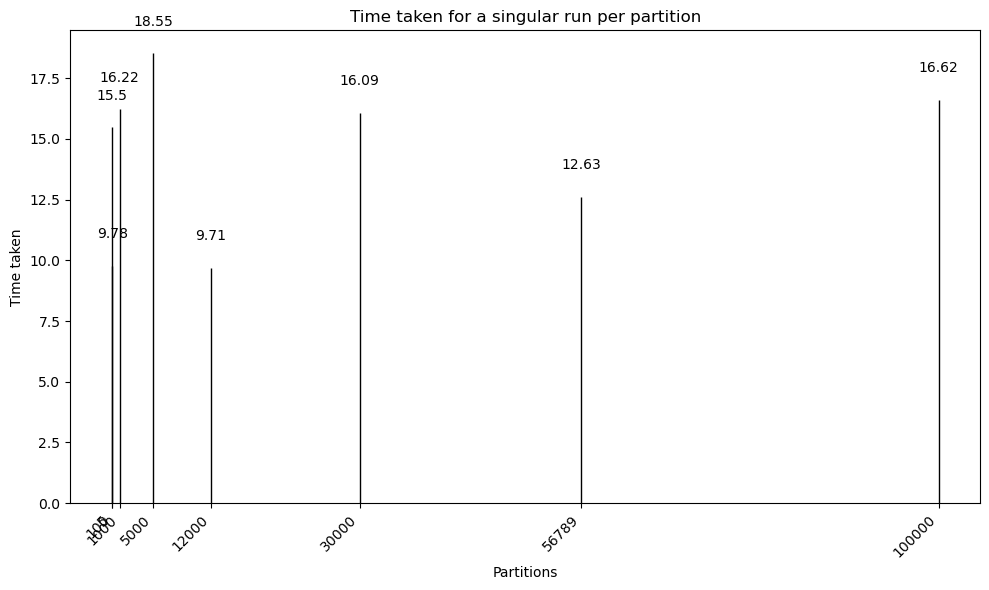

In [80]:
#Plotting a graph with the data of partitions vs time taken for a singular run

categories = possible_partitions
values = single_instance_times
plt.figure(figsize=(10,6))

plt.bar(categories, values, align = 'center', color = "blue", edgecolor = "black", width = 0.6)

# Add labels and title
plt.xlabel('Partitions')
plt.ylabel('Time taken')
plt.title('Time taken for a singular run per partition')

# Add values above the bars
for category, value in zip(categories, values):
    plt.text(category, value+1, str(round(value,2)), ha='center', va='bottom')

# Show the plot
plt.xticks(categories, rotation=45, ha = "right")
plt.tight_layout()
plt.show()



In [88]:
#Execute the partitioned hash join sort algorithm and check the average time required for processing
avg_times = []
for i in possible_partitions:
    i = int(i)
    avg = []
    for j in range(0,3):
        start_time = time.time()
        joins_partavg_1=hash_join_partitioned(list_follows,list_friendOf, i)
        joins_partavg_2=hash_join_partitioned(joins_partavg_1,list_likes, i)
        joins_partavg_3=hash_join_partitioned(joins_partavg_2,list_hasReview, i) 
        end_time = time.time()
        time_taken = end_time - start_time
        avg.append(time_taken)
    avg_time = sum(avg) / len(avg)
    print(len(joins_partavg_3))
    print("Avg Time taken for "+ str(i) +" partitions:", avg_time)
    avg_times.append(avg_time)


143202
Avg Time taken for 5 partitions: 11.304958502451578
143202
Avg Time taken for 100 partitions: 11.441999197006226
143202
Avg Time taken for 1000 partitions: 9.715176741282145
143202
Avg Time taken for 5000 partitions: 11.22727108001709
143202
Avg Time taken for 12000 partitions: 11.095339377721151
143202
Avg Time taken for 30000 partitions: 9.789183934529623
143202
Avg Time taken for 56789 partitions: 11.145448128382364
143202
Avg Time taken for 100000 partitions: 10.98039690653483


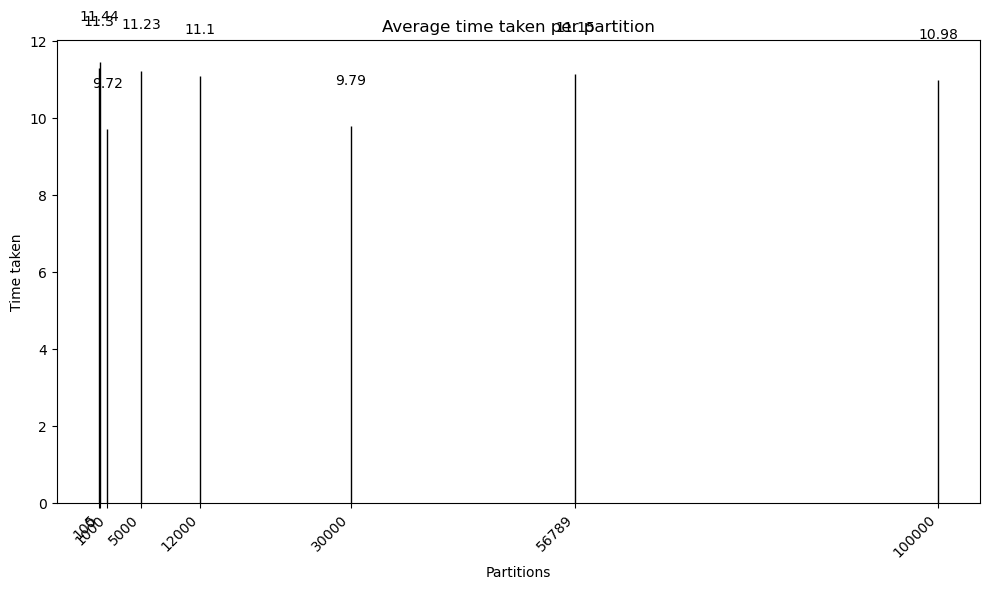

In [89]:
#Plotting a graph with the data of partitions vs average time taken


categories = possible_partitions
values = avg_times
plt.figure(figsize=(10,6))

plt.bar(categories, values, align = 'center', color = "blue", edgecolor = "black", width = 0.6)

# Add labels and title
plt.xlabel('Partitions')
plt.ylabel('Time taken')
plt.title('Average time taken per partition')

# Add values above the bars
for category, value in zip(categories, values):
    plt.text(category, value+1, str(round(value,2)), ha='center', va='bottom')

# Show the plot
plt.xticks(categories, rotation=45, ha = "right")
plt.tight_layout()
plt.show()



In [85]:
# Print the first 50 rows of the hash sort result as per the query
table = PrettyTable()

def get_columns(data, columns_to_include):
    return [[row[i] for i in columns_to_include] for row in data]

columns_to_include = [0, 1, 3, 5, 7]

# Outputting the required fields as per the question query
table.field_names = ['follows.Subject','follows.Object', 'friendOf.Object','likes.Object','hasReview.Object']

columns_data = get_columns(join_all, columns_to_include)
for row in columns_data[0:50]:
    table.add_row(row)
print(table)

+-----------------+----------------+-----------------+--------------+------------------+
| follows.Subject | follows.Object | friendOf.Object | likes.Object | hasReview.Object |
+-----------------+----------------+-----------------+--------------+------------------+
|    User97342    |   User23602    |    User32385    | Product10327 |   Review129280   |
|    User77572    |   User89637    |    User44326    | Product22272 |   Review85767    |
|    User70914    |   User96145    |    User76429    | Product7139  |   Review116467   |
|     User9424    |    User9032    |     User147     | Product21911 |    Review4274    |
|    User87936    |   User57846    |    User22045    | Product14732 |   Review47326    |
|    User18302    |   User30671    |    User56709    | Product9405  |   Review69618    |
|    User35077    |   User36506    |    User56934    | Product2606  |   Review118698   |
|    User55192    |   User14672    |    User99824    | Product23731 |   Review40866    |
|    User37937    |  

In [86]:
# Print the first 50 rows of the merge join sort result as per the query
table = PrettyTable()

def get_columns(data, columns_to_include):
    return [[row[i] for i in columns_to_include] for row in data]

columns_to_include = [0, 1, 3, 5, 7]

# Outputting the required fields as per the question query
table.field_names = ['follows.Subject','follows.Object', 'friendOf.Object','likes.Object','hasReview.Object']

columns_data = get_columns(joins_3, columns_to_include)
for row in columns_data[0:50]:
    table.add_row(row)
print(table)

+-----------------+----------------+-----------------+--------------+------------------+
| follows.Subject | follows.Object | friendOf.Object | likes.Object | hasReview.Object |
+-----------------+----------------+-----------------+--------------+------------------+
|    User57978    |   User14527    |    User10020    |   Product1   |   Review18727    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review79433    |
|    User57978    |   User14527    |    User10020    |   Product1   |    Review5260    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review62170    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review33460    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review135807   |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review19682    |
|    User57978    |   User14527    |    User10020    |   Product1   |   Review94224    |
|    User57978    |  

In [87]:
# Print the first 50 rows of the partitioned hash sort result as per the query
table = PrettyTable()

def get_columns(data, columns_to_include):
    return [[row[i] for i in columns_to_include] for row in data]

columns_to_include = [0, 1, 3, 5, 7]

# Outputting the required fields as per the question query
table.field_names = ['follows.Subject','follows.Object', 'friendOf.Object','likes.Object','hasReview.Object']

columns_data = get_columns(joins_part_3, columns_to_include)
for row in columns_data[0:50]:
    table.add_row(row)
print(table)

+-----------------+----------------+-----------------+--------------+------------------+
| follows.Subject | follows.Object | friendOf.Object | likes.Object | hasReview.Object |
+-----------------+----------------+-----------------+--------------+------------------+
|    User56996    |   User97362    |    User99985    |   Product1   |   Review18727    |
|    User56996    |   User97362    |    User99985    |   Product1   |   Review79433    |
|    User56996    |   User97362    |    User99985    |   Product1   |    Review5260    |
|    User56996    |   User97362    |    User99985    |   Product1   |   Review62170    |
|    User56996    |   User97362    |    User99985    |   Product1   |   Review33460    |
|    User56996    |   User97362    |    User99985    |   Product1   |   Review135807   |
|    User56996    |   User97362    |    User99985    |   Product1   |   Review19682    |
|    User56996    |   User97362    |    User99985    |   Product1   |   Review94224    |
|    User56996    |  